# An example of using Open Humans notebooks for fitbit data analysis

## Getting started

In this notebook we want to plot some of our own `fitbit` data. If you want to run this notebook on your personal data in the [*Open Humans Notebooks*](https://notebooks.openhumans.org) you need to have [*Fitbit*](https://www.openhumans.org/activity/fitbit) data in your Open Humans account.

#### Initialize packages
We'll need some Python packages to get our personal data out of Open Humans and to play around with it.

In [1]:
%matplotlib inline

import os, requests, json
import datetime
import pandas as pd
import matplotlib
import numpy as np
import matplotlib.pyplot as plt

Let's now start by getting a list of all the data we have on Open Humans. To do this we need our `access_token`. Using the `os` library we can access it from the environment variables which are set in our notebooks using `os.environ.get('OH_ACCESS_TOKEN')`

In [2]:
response = requests.get("https://www.openhumans.org/api/direct-sharing/project/exchange-member/?access_token={}".format(os.environ.get('OH_ACCESS_TOKEN')))
user = json.loads(response.content)

We now have a `json` object that contains all the details about our user account. We can look at it:

In [3]:
#user #commented out to not leak all download links ;)
#os.environ.get("OH_ACCESS_TOKEN")
print("not for the published notebook ;-)")

not for the published notebook ;-)


Amongst the keys we see that `user["data"]` gives us a list with all data files. Iterating over it gives us the following:

In [4]:
for i,f in enumerate(user['data']):
    print("{}\t{}".format(i,f['basename']))

0	1.json
1	healthkit-export_2015-11-01_2015-11-30_1511288864.58225.json
2	healthkit-export_2015-12-01_2015-12-31_1511288864.58225.json
3	healthkit-export_2015-12-31_2016-01-31_1511297617.26078.json
4	healthkit-export_2016-02-01_2016-02-29_1511297617.26078.json
5	healthkit-export_2016-03-01_2016-03-31_1511297617.26078.json
6	healthkit-export_2016-04-01_2016-04-30_1511297617.26078.json
7	healthkit-export_2016-05-01_2016-05-31_1511297617.26078.json
8	healthkit-export_2016-06-01_2016-06-30_1511297617.26078.json
9	healthkit-export_2016-07-01_2016-07-31_1511297617.26078.json
10	healthkit-export_2016-08-01_2016-08-31_1511297617.26078.json
11	healthkit-export_2016-09-01_2016-09-30_1511297617.26078.json
12	healthkit-export_2016-10-01_2016-10-31_1511297617.26078.json
13	healthkit-export_2016-11-01_2016-11-30_1511297617.26078.json
14	healthkit-export_2016-12-01_2016-12-31_1511297617.26078.json
15	healthkit-export_2017-01-01_2017-01-31_1511297617.26078.json
16	healthkit-export_2017-02-01_2017-02-2

Let's iterate again and grab ouy fitbit data 

## Getting Fitbit data

In [5]:
for f in user['data']:
    if f['source'] == "fitbit":
        fitbit_download_url = f['download_url']
        break
if not fitbit_download_url: 
    print("NO FITBIT DATA FOUND!")

To download the data we can use `requests` and subsequently convert the downloaded content into a `JSON` object

In [6]:
fitbit_temp = requests.get(fitbit_download_url).content
fitbit = json.loads(fitbit_temp)
fitbit.keys()

dict_keys(['sleep-start-time', 'awake-minutes', 'tracker-minutes-very-active', 'profile', 'minutes-to-sleep', 'tracker-floors', 'sleep-minutes', 'sleep-awakenings', 'tracker-minutes-lightly-active', 'tracker-calories', 'activities-overview', 'weight-log', 'time-in-bed', 'tracker-distance', 'sleep-minutes-after-wakeup', 'tracker-minutes-fairly-active', 'tracker-elevation', 'weight', 'heart', 'tracker-steps', 'sleep-efficiency', 'tracker-minutes-sedentary', 'tracker-activity-calories'])

The keys give us an idea what data is in our fitbit store. Let's have a quick look at the step counts. To do this we convert our JSON file into a `pandas` dataframe which can then be used for plotting.

## Visualizing Fitbit steps

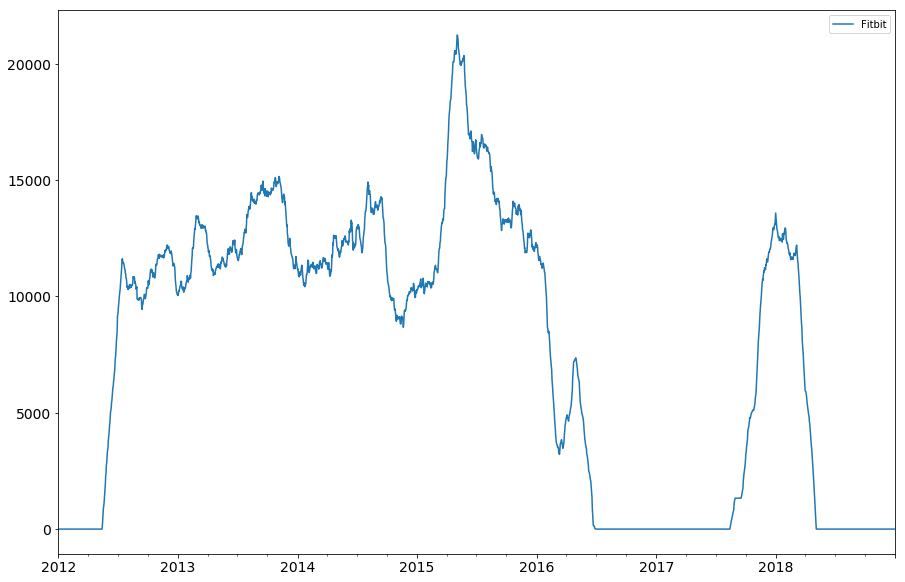

In [7]:
dates = []
steps = []
for year in fitbit['tracker-steps']:
    for entry in fitbit['tracker-steps'][year]['activities-tracker-steps']:
        dates.append(datetime.datetime.strptime(entry['dateTime'], '%Y-%m-%d'))
        steps.append(int(entry['value']))
fitbit_df = pd.DataFrame(data = {'date': dates, 
                          'steps': steps})
fitbit_df.sort_values(by=['date'],inplace=True)
fitbit_df.index = fitbit_df["date"]

fitbit_df = fitbit_df.groupby(fitbit_df.index.date).sum()
fitbit_df.index = pd.to_datetime(fitbit_df.index)
fitbit_dfr = fitbit_df.rolling('60d').mean()
fitbit_pt = fitbit_dfr.plot(y=['steps'],figsize=(15,10),fontsize=14)
fitbit_pt.legend(["Fitbit"])

All days with zero steps are most likely these days in which no fitbit tracker was worn at all and are thus not super Interesting. Nevertheless we can see some variation along the time, with a somewhat repeating pattern. 

Let's also have a look at our step histogram, i.e. on how many days did we run a certain amount of steps. But let's first remove all the days with zero steps, because otherwise we'll not be able to see much due to the overwhelming number of days with no data.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f17cc263e80>]], dtype=object)

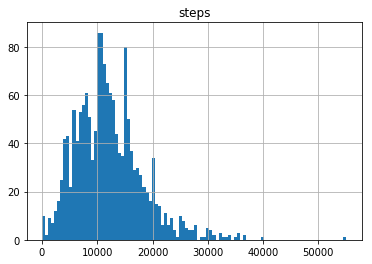

In [8]:
fitbit_df = fitbit_df.replace(0, np.nan)
fitbit_df.hist(bins=100)

We can see that the daily step counts appear to be largely follow a normal distribution, if a somewhat right-skewed one. More intersting though are the gaps and peaks we see: Peaks can be seen at step count intervals that are just above the limits at which Fitbit gives out achievements/awards! 

E.g. Fitbit hands out stickers for getting 10,000 steps. Consequentially we can see much more daily step counts than expected that fall in the range of `10,000-10,999 steps`, while step counts of `9,000-9,999` are suspiciously absent. 

And we can see the same effect at the other award-giving thresholds: 5,000 steps, 15,000 steps, 20,000 steps and even somewhat at 35,000 steps! So it seems that gamification works for me!

## Resting Heart Rates
Let's now also quickly dive into the resting heart rate data. If you're wearing a sufficiently modern `Fitbit` tracker you will have this data as well. 

In a first step we export the heart-rate data from our complete `fitbit`-json object. The data here is structured a bit differently, but overall the approach is the same:

In [9]:
dates = []
resting_hr = []

for month_year in fitbit['heart']:
    for day in (fitbit['heart'][month_year]['activities-heart']):
        if "restingHeartRate" in day['value'].keys():
            dates.append(datetime.datetime.strptime(day['dateTime'], '%Y-%m-%d'))
            resting_hr.append(day['value']['restingHeartRate'])

fitbit_df_hr = pd.DataFrame(data = {'date': dates, 
                          'resting_hr': resting_hr})
fitbit_df_hr.sort_values(by=['date'],inplace=True)
fitbit_df_hr.index = fitbit_df_hr["date"]

fitbit_df_hr = fitbit_df_hr.groupby(fitbit_df_hr.index.date).sum()
fitbit_df_hr.index = pd.to_datetime(fitbit_df_hr.index)

Let's now also plot a histogram of the heart-rate, along with some basic statistics: 

The average measured resting heart rate was: 60.67099567099567 with a standard deviation of 4.4439120514499875
The median measured resting heart rate was: 60.0


The maximum measured resting heart rate was: 76
The minimal measured resting heart rate was: 52


And here's the resting heart rate distribution:


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f17cc145a20>]], dtype=object)

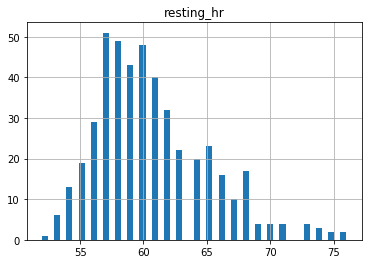

In [10]:
print('The average measured resting heart rate was: {} with a standard deviation of {}'.format(
    fitbit_df_hr['resting_hr'].mean(),
    fitbit_df_hr['resting_hr'].std()))
print('The median measured resting heart rate was: {}'.format(fitbit_df_hr['resting_hr'].median()))
print("\n")
print('The maximum measured resting heart rate was: {}'.format(fitbit_df_hr['resting_hr'].max()))
print('The minimal measured resting heart rate was: {}'.format(fitbit_df_hr['resting_hr'].min()))
print("\n")
print("And here's the resting heart rate distribution:")
fitbit_df_hr.hist(bins=50)

We can now also merge the `step` data along with the `resting heart rate` data and see whether there is any correlation between the two:

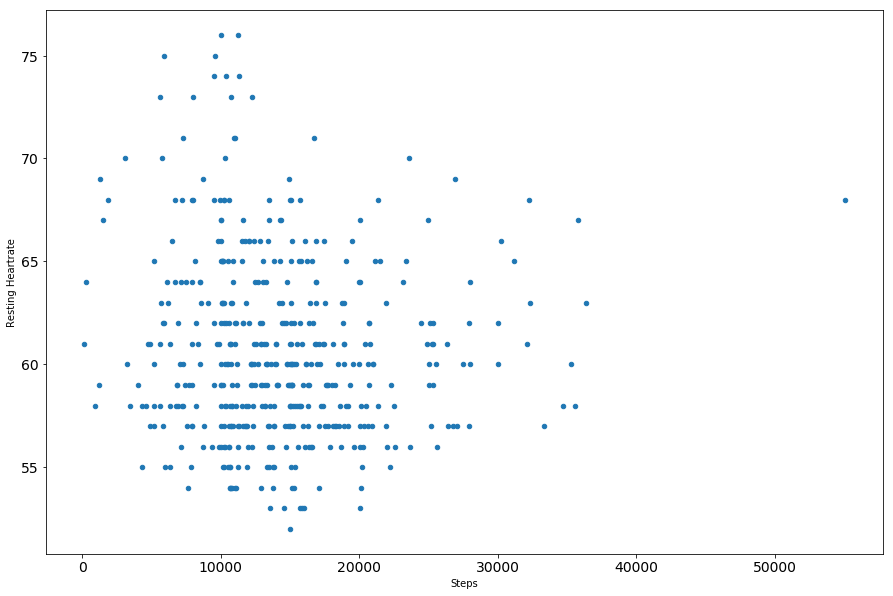

In [11]:
fitbit_df_merged = fitbit_df_hr.reset_index().merge(fitbit_df.reset_index())
scatter_pt = fitbit_df_merged.plot.scatter("steps", "resting_hr",figsize=(15,10),fontsize=14)
scatter_pt.set_xlabel("Steps")
scatter_pt.set_ylabel("Resting Heartrate")

Alas, this doesn't seem to be the case, though it is hard to say as most data points fall inside a rather narrow band of step counts and heart rate. How will you now explore your own data?

## Bonus: Elevation/Floors
Yes, the same approach also works for your elevation/floor climbing tracking:

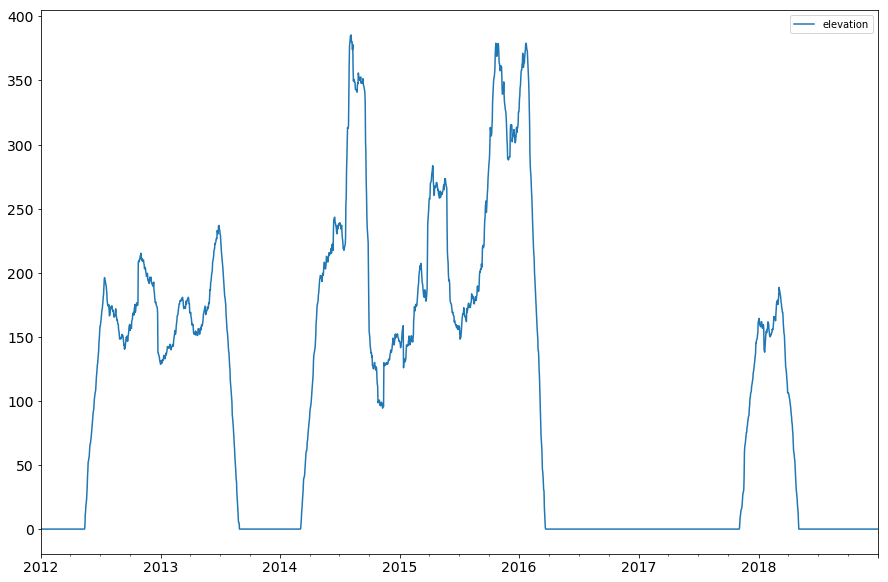

In [12]:
dates = []
elevation = []
for year in fitbit['tracker-elevation']:
    for entry in fitbit['tracker-elevation'][year]['activities-tracker-elevation']:
        dates.append(datetime.datetime.strptime(entry['dateTime'], '%Y-%m-%d'))
        elevation.append(int(entry['value']))
fitbit_df_elevation = pd.DataFrame(data = {'date': dates, 
                          'elevation': elevation})
fitbit_df_elevation.sort_values(by=['date'],inplace=True)
fitbit_df_elevation.index = fitbit_df_elevation["date"]

fitbit_df_elevation = fitbit_df_elevation.groupby(fitbit_df_elevation.index.date).sum()
fitbit_df_elevation.index = pd.to_datetime(fitbit_df_elevation.index)
fitbit_dfr_elevation = fitbit_df_elevation.rolling('60d').mean()
fitbit_dfr_elevation = fitbit_dfr_elevation.plot(y=['elevation'],figsize=(15,10),fontsize=14)
fitbit_pt.legend(["Fitbit"])

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f17c9682d68>]], dtype=object)

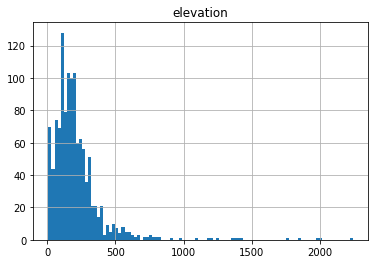

In [13]:
fitbit_df_elevation = fitbit_df_elevation.replace(0, np.nan)
fitbit_df_elevation.hist(bins=100)